In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.utils_contributions import *
import torch.nn.functional as F
from src.contributions import ModelWrapper, LMModelWrapperCaptum, interpret_sentence, occlusion
import pandas as pd
import seaborn as sns
import torch.nn as nn
import random
random.seed(10)
import pandas as pd

from lgd_binary_classifier.dataset import LGDBinaryDataset, collate

from collections import defaultdict

device = "cuda" if torch.cuda.is_available() else "cpu"


# Subject-verb agreement

In [3]:
model_name = 'bert_bin'
dataset_name = 'sva'
# No dataset to load
model, tokenizer, dataset_partition = load_model_data(model_name, dataset_name)

Loading bert_bin ...
Loading sva ...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
text = text.replace('***mask***',tokenizer.mask_token)
pt_batch = tokenizer(text, return_tensors="pt").to(device)
target_idx = (pt_batch['input_ids'][0] == tokenizer.mask_token_id).nonzero(as_tuple=True)
target_idx = target_idx[0].item() # position of the masked verb
tokenized_text = tokenizer.convert_ids_to_tokens(pt_batch["input_ids"][0])

In [6]:
tokenized_text

['[CLS]',
 'the',
 'pictures',
 'of',
 'some',
 'hat',
 '[MASK]',
 'scar',
 '##ing',
 'marcus',
 '.',
 '[SEP]']

### Tokenize text

In [4]:
i=8
pt_batch, tokenized_text, target_idx = prepare_sva_sentence(i,dataset_partition,tokenizer)
input_ids = pt_batch['input_ids']
print(tokenized_text)

['[CLS]', 'abundant', 'wall', 'paintings', 'and', 'icon', '##osta', '##sis', '[MASK]', 'the', 'walls', ',', 'dating', 'after', 'the', 'church', "'", 's', 'reconstruction', 'in', '1835', '.', '[SEP]']


## Forward pass

In [5]:
model_wrapped = ModelWrapper(model)
prediction_scores, hidden_states, attentions, contributions_data = model_wrapped(pt_batch)
if 'bin' in model_name:
    print(prediction_scores.size())
    prediction_scores = torch.squeeze(prediction_scores)
    prob_pred_class = torch.sigmoid(prediction_scores[target_idx])
    # if prob_pred_class >= 0.5:
    #     pred_class = 1
    # else:
    #     pred_class = 0
    #     prob_pred_class = 1 - prob_pred_class
    # print(pred_class)
    # print(prob_pred_class)
# else:
#     probs = torch.nn.functional.softmax(prediction_scores, dim=-1)
#     pred_ind = torch.argmax(probs[0][target_idx])
#     print(pred_ind)
#     pred = torch.max(probs[0][target_idx])
#     print('predicted token', tokenizer.convert_ids_to_tokens(pred_ind.item()))
#     print('probability of highest predicted token', pred)

torch.Size([1, 23, 1])


In [6]:
prob_pred_class

tensor(0.0046, device='cuda:0')

In [48]:
# model_wrapped = ModelWrapper(model)
# prediction_scores, hidden_states, attentions, contributions_data = model_wrapped(pt_batch)
# if 'bin' in model_name:
#     prediction_scores = torch.squeeze(prediction_scores)
#     actual_verb_score = torch.sigmoid(prediction_scores[target_idx])
#     print(actual_verb_score)

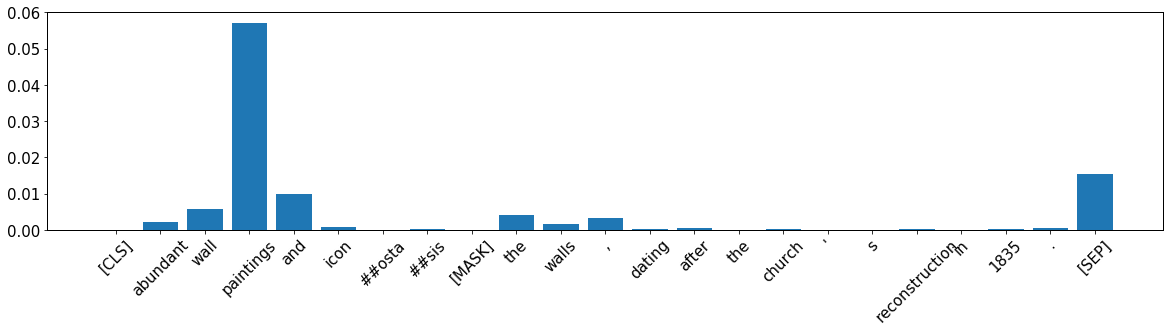

In [7]:
diffs = occlusion(model_wrapped, tokenizer, target_idx, prob_pred_class, pt_batch)
plot_histogram(diffs,tokenized_text)

### Getting attention weights, attention vector norms and contributions from ALTI method

In [35]:
# # Wrong
# _attentions = [att.detach().cpu().numpy() for att in attentions]
# attentions_mat = np.asarray(_attentions)[:,0] # (num_layers,num_heads,src_len,src_len)
# att_mat_sum_heads = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
# print(att_mat_sum_heads.shape)
# normalized_model_norms = normalize_contributions(contributions_data['transformed_vectors_norm'],scaling='sum_one')
# resultant_norm = resultants_norm = torch.norm(torch.squeeze(contributions_data['resultants']),p=1,dim=-1)
# normalized_contributions = normalize_contributions(contributions_data['contributions'],scaling='sum_one',resultant_norm=resultant_norm)#min_sum


In [8]:
_attentions = [att.detach().cpu().numpy() for att in attentions]
attentions_mat = np.asarray(_attentions)[:,0] # (num_layers,num_heads,src_len,src_len)
att_mat_sum_heads = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
normalized_model_norms = normalize_contributions(contributions_data['transformed_vectors_norm'],scaling='sum_one')
resultant_norm = resultants_norm = torch.norm(torch.squeeze(contributions_data['resultants']),p=1,dim=-1)
# ALTI Requires scaling = min_sum
normalized_contributions = normalize_contributions(contributions_data['contributions'],scaling='min_sum',resultant_norm=resultant_norm)


### Rollout with attention weights (Abnar and Zuidema, 2020)

In [9]:
joint_attentions = compute_rollout(att_mat_sum_heads)

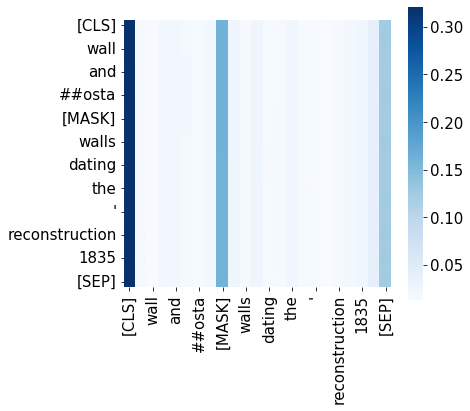

In [10]:
layer = -1
plt.figure(figsize=(6,6))
df = pd.DataFrame(joint_attentions[layer].cpu().detach().numpy(),columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Blues",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

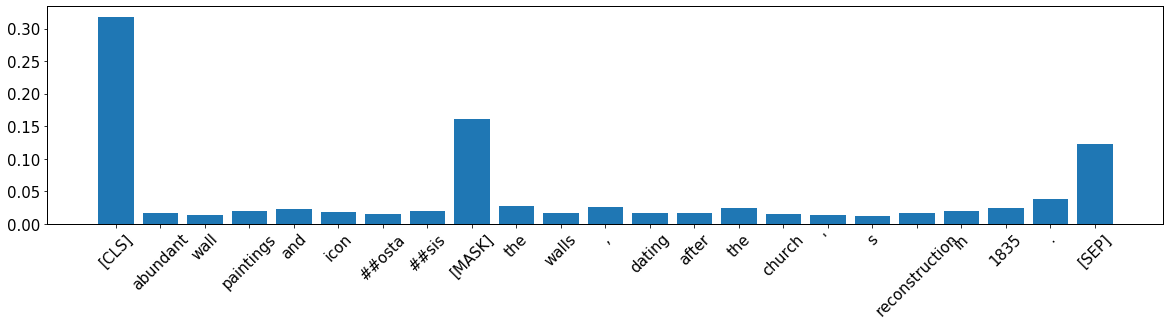

In [11]:
joint_attention_layer = -1
pos = target_idx
joint_attentions_mask = joint_attentions[joint_attention_layer][pos]
plot_histogram(joint_attentions_mask,tokenized_text)

### Attention rollout + |T(x_j)| (Kobayashi et al., 2021)

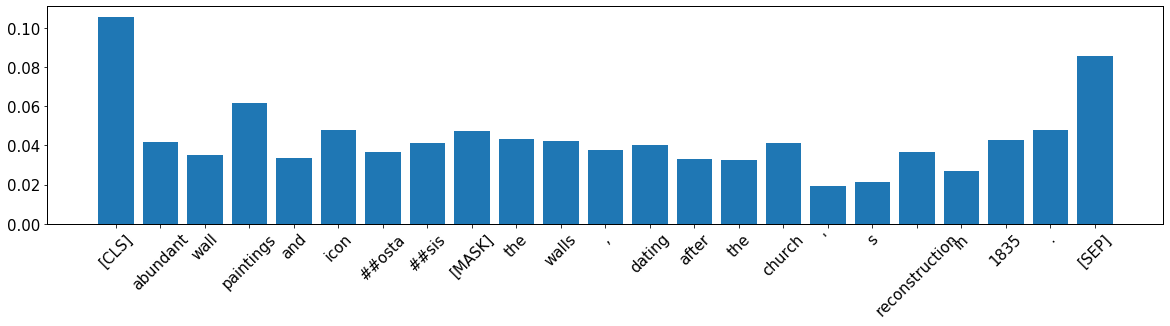

In [12]:
norms_mix = compute_joint_attention(normalized_model_norms)
joint_attention_layer = -1
pos = target_idx
norms_mix_mask = norms_mix[joint_attention_layer][pos]
plot_histogram(norms_mix_mask,tokenized_text)

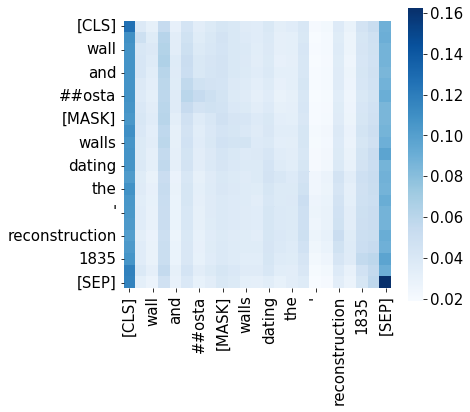

In [13]:
norms_mix = norms_mix.detach().cpu().numpy()
plt.figure(figsize=(6,6))
joint_attention_layer = -1
df = pd.DataFrame(norms_mix[joint_attention_layer],columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Blues",square=True)
plt.gcf().subplots_adjust(bottom=0.2)


### ALTI

torch.float32


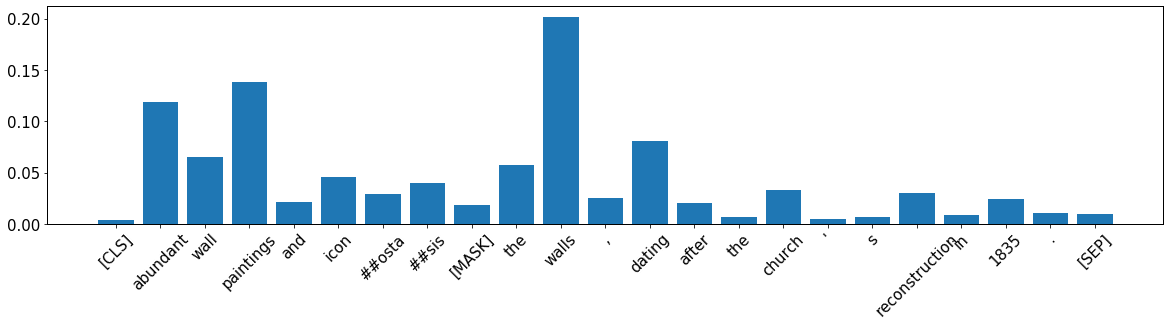

In [14]:
print(normalized_contributions.dtype)
contributions_mix = compute_joint_attention(normalized_contributions)
joint_attention_layer = -1
pos = target_idx
contributions_mix_mask = contributions_mix[joint_attention_layer][pos]
plot_histogram(contributions_mix_mask,tokenized_text)

In [15]:
# # contributions_mix = contributions_mix.detach().cpu().numpy()
# # plt.figure(figsize=(8,8))

# #joint_attention_normalized_layer = contributions_mix[joint_attention_layer] / joint_attentions[joint_attention_layer].sum(axis=-1)[...,None]
# df = pd.DataFrame(np.array(normalized_contributions[0],dtype='float64'),columns=tokenized_text,index=tokenized_text)
# sns.heatmap(df,cmap="Blues",square=True)#Reds,,center=0
# plt.gcf().subplots_adjust(bottom=0.2)


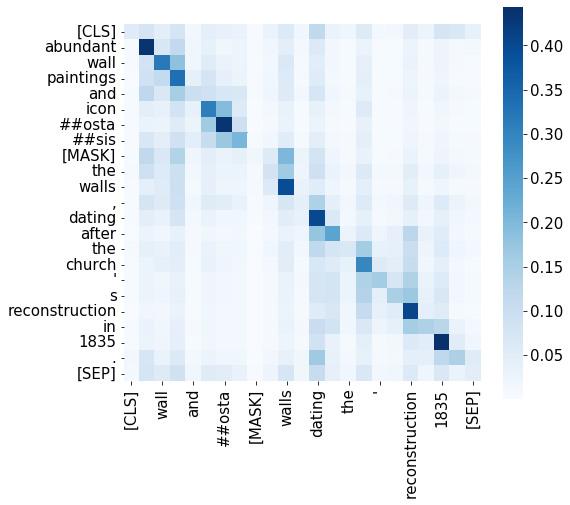

In [16]:
contributions_mix = contributions_mix.detach().cpu().numpy()
plt.figure(figsize=(8,8))

#joint_attention_normalized_layer = contributions_mix[joint_attention_layer] / joint_attentions[joint_attention_layer].sum(axis=-1)[...,None]
df = pd.DataFrame(np.array(contributions_mix[joint_attention_layer],dtype='float64'),columns=tokenized_text,index=tokenized_text)
sns.heatmap(df,cmap="Blues",square=True)#Reds,,center=0
plt.gcf().subplots_adjust(bottom=0.2)


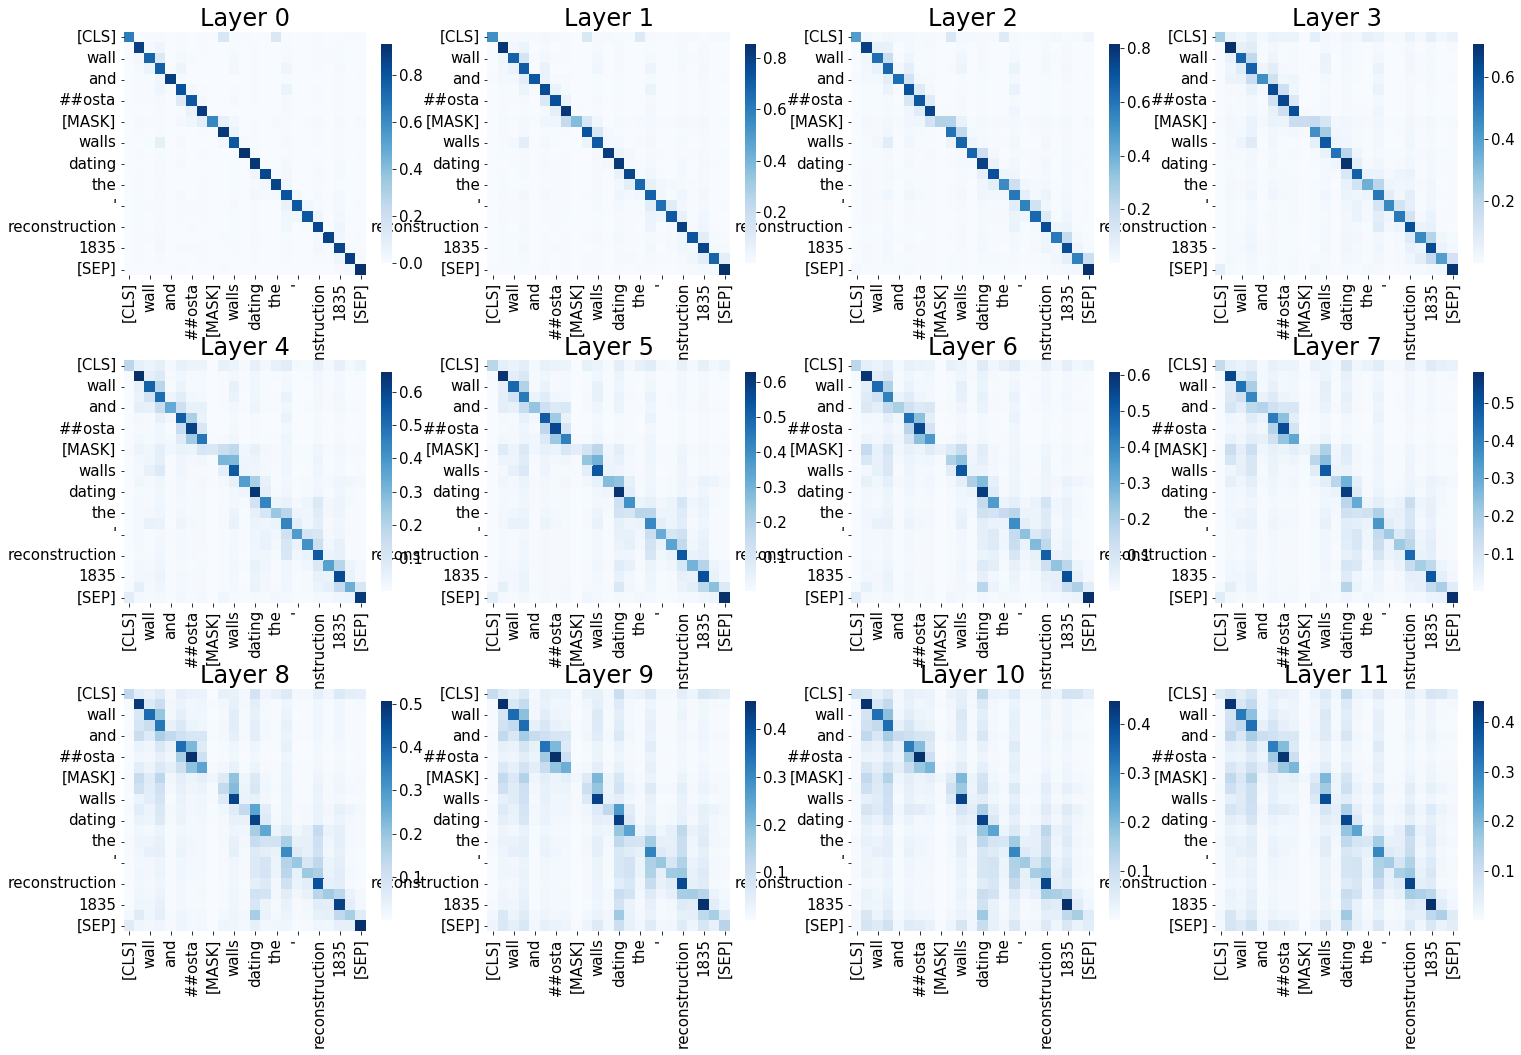

In [21]:
try:
    num_layers = model.config.num_hidden_layers
except:
    num_layers = model.config.n_layers

if num_layers == 12:
    fig, axs = plt.subplots(3, 4,figsize=(25,19),sharey=False)
    row = 4
    col = 4
elif num_layers == 6:
    fig, axs = plt.subplots(2, 3,figsize=(20,13),sharey=False)
    row = 3
    col = 3

for layer in range(0,num_layers):
    df = pd.DataFrame(np.array(contributions_mix[layer],dtype='float64'),columns=tokenized_text,index=tokenized_text)
    sns.heatmap(df,cmap="Blues",square=True,ax=axs[int(layer/row),layer%col],cbar_kws={'shrink': 0.8})
    axs[int(layer/row),layer%col].set_title('Layer ' + str(layer))
    axs[int(layer/row),layer%col].tick_params(axis='x', rotation=90)
    plt.gcf().subplots_adjust(bottom=0.2)

## Other attribution methods with Captum

In [18]:
bert_model_wrapper = LMModelWrapperCaptum(model)

In [19]:
grad_attributions = interpret_sentence(bert_model_wrapper, tokenizer, input_ids, 'grad', target_idx)
grad_input_attributions = interpret_sentence(bert_model_wrapper, tokenizer, input_ids, 'grad_input',target_idx)
grad_ig_attributions = interpret_sentence(bert_model_wrapper, tokenizer, input_ids, 'ig', target_idx)
grad_input_attributions = grad_input_attributions['mean']
grad_ig_attributions = grad_ig_attributions['mean']


In [20]:
# accumalate samples in this array for visualization purposes
vis_data_records_ig = []

def add_attributions_to_visualizer(attributions, tokens, label, vis_data_records):
    pred = 1
    attributions_min_max = normalize_attribution_visualization(attributions)
    attributions_min_max = attributions_min_max.cpu().detach().numpy()

    
    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions_min_max,
                            pred,
                            label,
                            label,
                            "label",
                            attributions_min_max.sum(),       
                            tokens[:len(attributions_min_max)],
                            0))
    return attributions_min_max

tokens = tokenizer.convert_ids_to_tokens(pt_batch["input_ids"][0].cpu().detach().numpy().tolist())
min_max_grad_attributions = add_attributions_to_visualizer(grad_attributions, tokens, target_idx, vis_data_records_ig)
min_max_grad_input_attributions = add_attributions_to_visualizer(grad_input_attributions, tokens, target_idx, vis_data_records_ig)
min_max_grad_ig_attributions = add_attributions_to_visualizer(grad_ig_attributions, tokens, target_idx, vis_data_records_ig)
min_max_joint_attention_rollout_mask = add_attributions_to_visualizer(joint_attentions_mask, tokens, target_idx, vis_data_records_ig)
min_max_norm_rollout_mask = add_attributions_to_visualizer(norms_mix_mask, tokens, target_idx, vis_data_records_ig)
blankout_mask = add_attributions_to_visualizer(diffs, tokens, target_idx, vis_data_records_ig)
min_max_contributions_mix_mask = add_attributions_to_visualizer(contributions_mix_mask, tokens, target_idx, vis_data_records_ig)
visualization.visualize_text(vis_data_records_ig);

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
8,8 (1.00),label,3.82,"[CLS] abundant wall paintings and icon ##osta ##sis [MASK] the walls , dating after the church ' s reconstruction in 1835 . [SEP]"
8,8 (1.00),label,18.15,"[CLS] abundant wall paintings and icon ##osta ##sis [MASK] the walls , dating after the church ' s reconstruction in 1835 . [SEP]"
8,8 (1.00),label,16.06,"[CLS] abundant wall paintings and icon ##osta ##sis [MASK] the walls , dating after the church ' s reconstruction in 1835 . [SEP]"
8,8 (1.00),label,2.31,"[CLS] abundant wall paintings and icon ##osta ##sis [MASK] the walls , dating after the church ' s reconstruction in 1835 . [SEP]"
8,8 (1.00),label,6.46,"[CLS] abundant wall paintings and icon ##osta ##sis [MASK] the walls , dating after the church ' s reconstruction in 1835 . [SEP]"
8,8 (1.00),label,1.80,"[CLS] abundant wall paintings and icon ##osta ##sis [MASK] the walls , dating after the church ' s reconstruction in 1835 . [SEP]"
8,8 (1.00),label,4.61,"[CLS] abundant wall paintings and icon ##osta ##sis [MASK] the walls , dating after the church ' s reconstruction in 1835 . [SEP]"


## Prepare paper saliency map tables

In [37]:
attributions_list = []
attributions_list.append(min_max_grad_attributions)
attributions_list.append(min_max_grad_input_attributions)
attributions_list.append(min_max_grad_ig_attributions)
attributions_list.append(min_max_joint_attention_rollout_mask)
attributions_list.append(min_max_norm_rollout_mask)
attributions_list.append(blankout_mask)
attributions_list.append(min_max_contributions_mix_mask)
prepare_colorize()
methods_list = [0,1,2,5,6]
methods_dict = {0:'$\\text{Grad}_{l2}$', 1:'Grad $\\cdot$ input', 2:'Integrated Gradients', 3:'Attn Rollout', 4:'Norm Rollout', 5: 'Blank-out', 6:'ALTI'}
figure_saliency(attributions_list, tokenized_text,methods_list,methods_dict)

## Correlation between methods

In [3]:
!python correlations.py distilbert sva 500

Loading distilbert ...
Loading sva ...
